This notebook includes the n-gram analysis on 4 telegram channels 

In [2]:
from pymystem3 import Mystem
from string import punctuation
m = Mystem()
import nltk
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
import zstandard
import pathlib
import os
import ujson as json
import pandas as pd
from nltk import ngrams
import re
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy 
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import calendar
import spacy
import stanza
import spacy_stanza
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/apaarbawa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv("combined_telegram_data.csv")
df["post_datetime"] = pd.to_datetime(df['post_datetime'])
df['post_date'] = pd.to_datetime(df['post_datetime'].dt.date)

In [4]:
b_df = df[(df['post_date'] < datetime(2022,2,24))]
a_df = df[(df['post_date'] >= datetime(2022,2,24))]

In [5]:
import re
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def cleaner(post):
    post = re.sub("@[A-Za-z0-9]+","",post) # Remove @ sign
    post = re.sub('http://\S+|https://\S+','', post) # remove links
    post = re.sub('http[s]?://\S+', '', post) # remove links
    post = re.sub(r"http\S+", "", post) #remove links
    post = re.sub(r"[\d-]","",post) # remove numbers
    post = post=re.sub(r'@user\d\d\d\d',"",post) #using regex finding the word having @user%
    post = re.sub("[‼️❗️⚡️⚡🇸🇾🇹🇷▪️📺🔺⬇️🚩☑️👊🏴🇷🇺🇺🇦()⚔️🛡️«»!:,#_'`]+","",post) # remove some of these special characters
    post = re.sub("[\n.]+"," ",post) #no \n
    post = post.replace("#", "").replace("_", "") #Remove hashtag sign but keep the text
    post = emoji_pattern.sub(r'', post) # no emoji
    post=re.sub(' +',' ',post) # removing multiple spaces
    post = post.strip()
    return post

## Stopwords

In [6]:
#NO NEED TO RUN BELOW CODE AGAIN AND AGAIN

nltk_stop_words = stopwords.words('russian')

# Download the stanza model if necessary
# stanza.download("ru")

# Initialize the pipeline
nlp = spacy_stanza.load_pipeline("ru")

spacy_stop_words = list(nlp.Defaults.stop_words)

# https://www.ranks.nl/stopwords/russian
ru_stopwords_1 = pd.read_excel("russian_stopwords.xlsx", header=None)[0].tolist()

# https://countwordsfree.com/stopwords/russian
f = open("stop_words_russian.json")
ru_stopwords_2 = json.load(f)

manual_stopwords = ["live", "телеграм", "soloviev", "соловьёв", "me/rvvoenkor", "соловьёвlive", "является", "заявил"]

stop_words = list(set(nltk_stop_words + spacy_stop_words + ru_stopwords_1 + ru_stopwords_2 + manual_stopwords))

2023-02-16 01:24:23 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-02-16 01:24:25 INFO: Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |
| pos       | syntagrus |
| lemma     | syntagrus |
| depparse  | syntagrus |
| ner       | wikiner   |

2023-02-16 01:24:25 INFO: Use device: cpu
2023-02-16 01:24:25 INFO: Loading: tokenize
2023-02-16 01:24:26 INFO: Loading: pos
2023-02-16 01:24:26 INFO: Loading: lemma
2023-02-16 01:24:26 INFO: Loading: depparse
2023-02-16 01:24:26 INFO: Loading: ner
2023-02-16 01:24:28 INFO: Done loading processors!


## Unigram

### After the war

In [ ]:
a_post_data = a_df['message'].copy()
a_post_data=a_post_data.drop(index=a_post_data[a_post_data.isnull()].index)
a_post_data=a_post_data.apply(cleaner)
a_post_data=a_post_data.drop(index=a_post_data[a_post_data==""].index)

In [8]:
#removing stop words
a_post_data = a_post_data.apply(lambda x: ' '.join([word for word in x.split() 
                                                if word.lower() not in (stop_words)]))

a_post_data=a_post_data.drop(index=a_post_data[a_post_data==""].index) #droping empty tweets or rows

In [9]:
a_post_data.reset_index(drop=True, inplace=True)

In [10]:
sample = a_post_data.copy()

In [11]:
#doing lemmatization
sample = sample.apply(lambda x: ' '.join([word for word in m.lemmatize(x.lower())
                                                if word != " " and word.strip() not in punctuation]))

In [12]:
# BELOW ONE IS TOO SLOWWW
# for i in range(len(a_post_data)):
#     a_post_data.loc[i] = nlp(a_post_data.loc[i]) 
#     print(f"message {i} done")
    
# or 

# a_post_data = a_post_data.apply(lambda x: nlp(x))

In [13]:
a__post_data = sample.copy()

In [14]:
l=list(a__post_data)
a_unigram=[word_tokenize(text) for text in l]

a_unigram=[[w.lower() for w in tokens if len(w)>1]for tokens in a_unigram]

a_unigramlist=[]
for i in a_unigram:
    a_unigramlist.extend(i)

In [15]:
a_freq = {}
for item in a_unigramlist: 
    if (item in a_freq):
        a_freq[item] += 1
    else:
        a_freq[item] = 1

In [16]:
#dict(sorted(a_freq.items(), key=lambda item: item[1],reverse=True))

In [83]:
a_freq_list = [(k, v) for k, v in a_freq.items()]

with open('after_war_unigrams.txt', 'w') as filehandle:
    for listitem in a_freq_list[:200]:
        filehandle.write(f'{listitem}\n')

In [17]:
a_freq["украина"] = a_freq["украина"] + a_freq["украинский"]
a_freq["россия"] = a_freq["россия"] + a_freq["российский"] + a_freq["рф"]
del a_freq["украинский"], a_freq["российский"], a_freq["рф"]

In [18]:
a_freq = dict(sorted(a_freq.items(), key=lambda item: item[1],reverse=True))

In [ ]:
россия: Russia
украина: Ukraine
всу: Armed foreces of Ukraine
район: Military
уничтожать: Destroy
сша: USA
бой: Battle
территория: Territory
днр: Donetsk People's Republic
армия: Army
противник: Enemy
боевой: Combat
война: War
боец: Fighter
киев: Kyiv
донбасс: Donbass
оборона: Defense
оружие: Weapon

In [19]:
a_freq

{'россия': 65434,
 'украина': 56746,
 'всу': 22247,
 'военный': 19098,
 'район': 15066,
 'область': 12571,
 'удар': 12026,
 'страна': 10631,
 'сила': 10566,
 'город': 10194,
 'уничтожать': 10081,
 'сша': 9751,
 'направление': 9248,
 'войско': 9210,
 'новый': 9106,
 'бой': 8701,
 'позиция': 8178,
 'территория': 8105,
 'днр': 8004,
 'армия': 7980,
 'противник': 7950,
 'боевой': 7912,
 'война': 7769,
 'пункт': 7744,
 'сообщать': 7495,
 'сторона': 7174,
 'идти': 6906,
 'боец': 6885,
 'киев': 6627,
 'продолжать': 6576,
 'действие': 6470,
 'русский': 6464,
 'подразделение': 6343,
 'работа': 6338,
 'житель': 6319,
 'помощь': 6173,
 'ракета': 6163,
 'часть': 6116,
 'фронт': 6115,
 'человек': 6049,
 'большой': 5956,
 'техника': 5925,
 'операция': 5756,
 'донбасс': 5664,
 'вс': 5653,
 'наносить': 5519,
 'день': 5444,
 'оборона': 5407,
 'получать': 5362,
 'оружие': 5343,
 'вопрос': 5320,
 'цель': 5282,
 'республика': 5196,
 'президент': 5177,
 'артиллерия': 5097,
 'боевик': 5068,
 'смотреть': 504

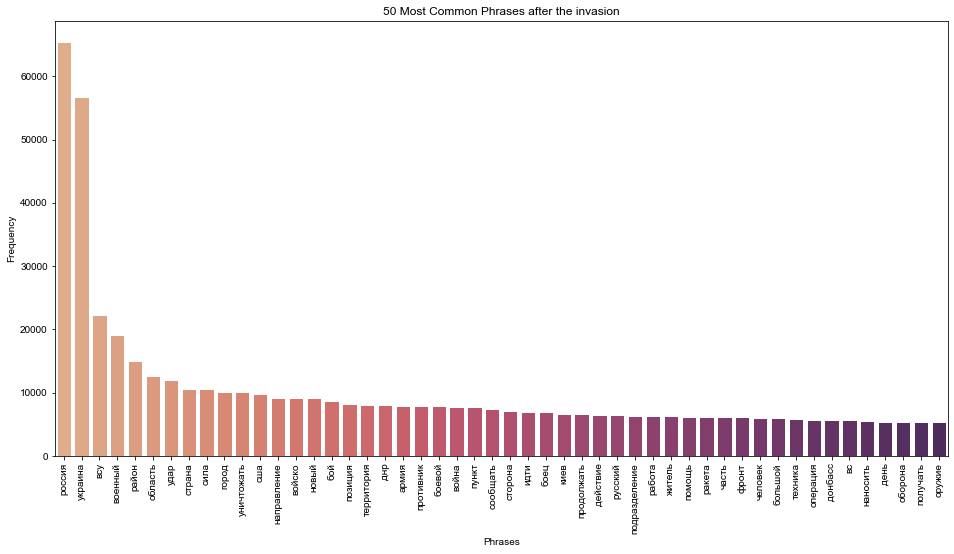

In [20]:
uni_data = {"words": list(a_freq.keys()),
           "count": list(a_freq.values())}

unigram_df = pd.DataFrame.from_dict(uni_data)

# Create the bar graph using Seaborn
fig, ax = plt.subplots(figsize=(16, 8))
sns.set(color_codes=True)
pal = sns.color_palette("flare", len(unigram_df[:50]["count"].tolist()))
rank = np.array(unigram_df[:50]["count"].tolist()).argsort().argsort()
ax = sns.barplot(x='words', y='count', data=unigram_df[:50], palette=np.array(pal[::-1])[rank])

# Add a title to the graph
plt.title('50 Most Common Phrases after the invasion')
plt.xticks(rotation=90)
plt.xlabel("Phrases")
plt.ylabel("Frequency")

# Show the graph
plt.show()

## Unigram 

### Before the war

In [113]:
b_post_data = b_df['message'].copy()
b_post_data=b_post_data.drop(index=b_post_data[b_post_data.isnull()].index)
b_post_data=b_post_data.apply(cleaner)
b_post_data=b_post_data.drop(index=b_post_data[b_post_data==""].index)

In [114]:
#removing stop words from each row in df
b_post_data = b_post_data.apply(lambda x: ' '.join([word for word in x.split() 
                                                if word.lower() not in (stop_words)]))

b_post_data=b_post_data.drop(index=b_post_data[b_post_data==""].index) #droping empty tweets or rows
b_post_data.reset_index(drop=True, inplace=True)

b_post_data = b_post_data.apply(lambda x: ' '.join([word for word in m.lemmatize(x.lower())
                                                if word != " " and word.strip() not in punctuation]))

b__post_data = b_post_data.copy()

In [115]:
l=list(b__post_data)
b_unigram=[word_tokenize(text) for text in l]

b_unigram = [[w.lower() for w in tokens if len(w)>1]for tokens in b_unigram]

b_unigramlist = []
for i in b_unigram:
    b_unigramlist.extend(i)

In [24]:
b_freq = {}
for item in b_unigramlist: 
    if (item in b_freq):
        b_freq[item] += 1
    else:
        b_freq[item] = 1

In [25]:
b_freq["украина"] = b_freq["украина"] + b_freq["украинский"]
b_freq["россия"] = b_freq["россия"] + b_freq["российский"] + b_freq["рф"]
del b_freq["украинский"], b_freq["российский"], b_freq["рф"]

In [26]:
b_freq = dict(sorted(b_freq.items(), key=lambda item: item[1],reverse=True))

In [84]:
b_freq_list = [(k, v) for k, v in b_freq.items()]

with open('before_war_unigrams.txt', 'w') as filehandle:
    for listitem in b_freq_list[:200]:
        filehandle.write(f'{listitem}\n')

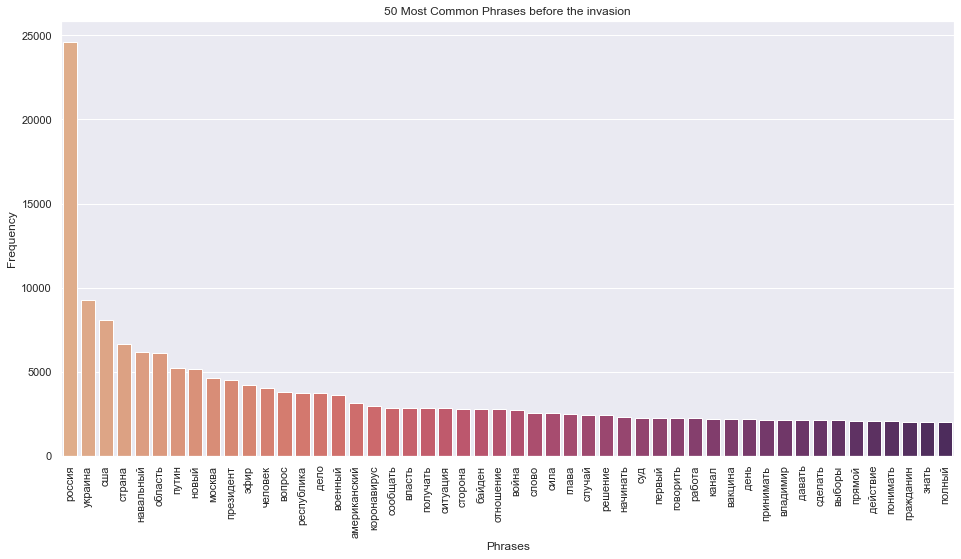

In [28]:
uni_data = {"words": list(b_freq.keys()),
           "count": list(b_freq.values())}

unigram_df = pd.DataFrame.from_dict(uni_data)

# Create the bar graph using Seaborn
fig, ax = plt.subplots(figsize=(16, 8))
sns.set(color_codes=True)
pal = sns.color_palette("flare", len(unigram_df[:50]["count"].tolist()))
rank = np.array(unigram_df[:50]["count"].tolist()).argsort().argsort()
ax = sns.barplot(x='words', y='count', data=unigram_df[:50], palette=np.array(pal[::-1])[rank])

# Add a title to the graph
plt.title('50 Most Common Phrases before the invasion')
plt.xticks(rotation=90)
plt.xlabel("Phrases")
plt.ylabel("Frequency")

# Show the graph
plt.show()

## Bigram

### After war

In [29]:
from gensim.models.phrases import Phrases, Phraser

#create bigrams

phrases = Phrases(a_unigram, min_count=1, threshold=2)
a_bigram = Phraser(phrases)

a_bigram_dict = dict()
for sent in a_bigram[a_unigram]:
        for s in sent:
            if s in a_bigram_dict.keys():
                a_bigram_dict[s]+=1
            else:
                a_bigram_dict[s]=1
                
a_bigram_freq={}
for k,v in a_bigram_dict.items():
    if '_' in k:
        a_bigram_freq[k]=v

In [30]:
# del a_bigram_freq["``_``"]
# del a_bigram_freq["``_''"]

In [31]:
a_bigram_freq = dict(sorted(a_bigram_freq.items(), key=lambda item: item[1],reverse=True))

In [86]:
a_bigram_list = [(k, v) for k, v in a_bigram_freq.items()]

with open('after_war_bigrams.txt', 'w') as filehandle:
    for listitem in a_bigram_list[:200]:
        filehandle.write(f'{listitem}\n')

In [ ]:
вс_рф, армия_россия, российский_войско, российский_военный: Russian armed forces
наносить_удар: Strikes
военный_операция: military_operation
специальный_военный: special_military

Among the regions:
херсонский_область: Kherson_region
харьковский_область: Kharkiv_region
запорожский_область: Zaporozhye_region
    
ракетный_удар: Rocket Strike


военный_техника: military_equipment
вооруженный_сила: armed_strength
    
киевский_режим: Kiev_regime

Among the people
владимир_путин

уничтожать_украинский: destroy ukrainian


In [32]:
#list(a_bigram_freq.keys())[50:100]

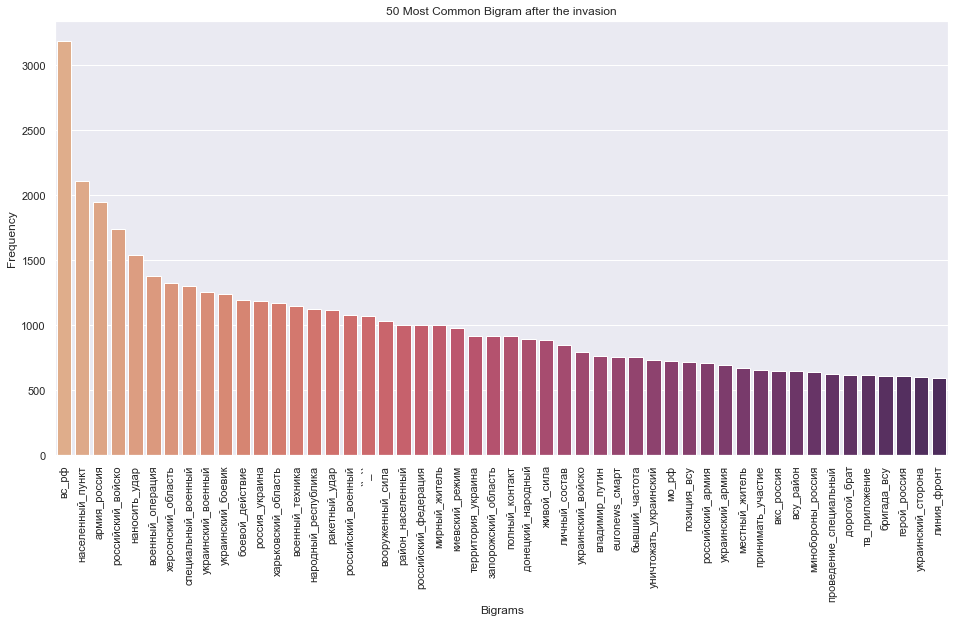

In [33]:
a_bigram_data = {"words": list(a_bigram_freq.keys()),
           "count": list(a_bigram_freq.values())}

bigram_df = pd.DataFrame.from_dict(a_bigram_data)

# Create the bar graph using Seaborn
fig, ax = plt.subplots(figsize=(16, 8))
sns.set(color_codes=True)
pal = sns.color_palette("flare", len(bigram_df[:50]["count"].tolist()))
rank = np.array(bigram_df[:50]["count"].tolist()).argsort().argsort()
ax = sns.barplot(x='words', y='count', data=bigram_df[:50], palette=np.array(pal[::-1])[rank])

# Add a title to the graph
plt.title('50 Most Common Bigram after the invasion')
plt.xticks(rotation=90)
plt.xlabel("Bigrams")
plt.ylabel("Frequency")

# Show the graph
plt.show()

## Bigram

### Before war

In [107]:
from gensim.models.phrases import Phrases, Phraser

#create bigrams

phrases = Phrases(b_unigram, min_count=1, threshold=2)
b_bigram = Phraser(phrases)

b_bigram_dict = dict()
for sent in b_bigram[b_unigram]:
        for s in sent:
            if s in b_bigram_dict.keys():
                b_bigram_dict[s]+=1
            else:
                b_bigram_dict[s]=1

In [108]:
b_bigram_freq={}
for k,v in b_bigram_dict.items():
    if '_' in k:
        b_bigram_freq[k]=v

In [109]:
del b_bigram_freq["``_``"]
del b_bigram_freq["``_''"]

In [110]:
b_bigram_freq = dict(sorted(b_bigram_freq.items(), key=lambda item: item[1],reverse=True))

In [111]:
b_bigram_list = [(k, v) for k, v in b_bigram_freq.items()]

with open('before_war_bigrams.txt', 'w') as filehandle:
    for listitem in b_bigram_list[:200]:
        filehandle.write(f'{listitem}\n')

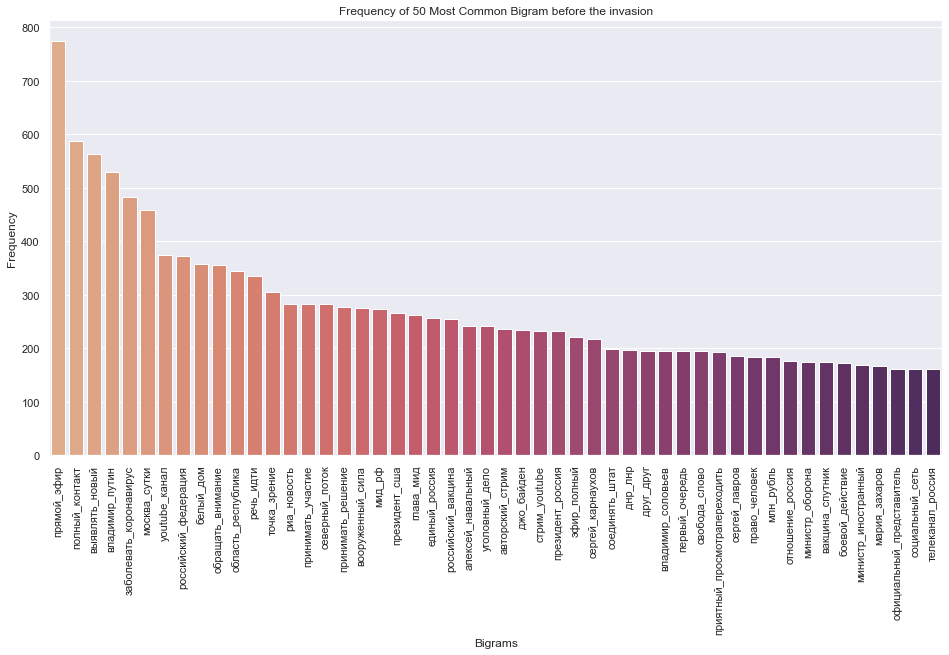

In [39]:
b_bigram_freq = {"words": list(b_bigram_freq.keys()),
           "count": list(b_bigram_freq.values())}

bigram_df = pd.DataFrame.from_dict(b_bigram_freq)

# Create the bar graph using Seaborn
fig, ax = plt.subplots(figsize=(16, 8))
sns.set(color_codes=True)
pal = sns.color_palette("flare", len(bigram_df[:50]["count"].tolist()))
rank = np.array(bigram_df[:50]["count"].tolist()).argsort().argsort()
ax = sns.barplot(x='words', y='count', data=bigram_df[:50], palette=np.array(pal[::-1])[rank])

# Add a title to the graph
plt.title('Frequency of 50 Most Common Bigram before the invasion')
plt.xticks(rotation=90)
plt.xlabel("Bigrams")
plt.ylabel("Frequency")

# Show the graph
plt.show()

## Trigram

### After war

In [40]:
a_trigram = Phrases(a_bigram[a_unigram], min_count=2,threshold=3)
a_trigram = Phraser(a_trigram)
a_trigram_dict = dict()

for sent in a_trigram[a_bigram[a_unigram]]:
    for s in sent:
        if s not in a_bigram_dict.keys() and s not in a_trigram_dict.keys():
            a_trigram_dict[s]=1
        elif s not in a_bigram_dict.keys():
            a_trigram_dict[s]+=1

In [41]:
a_trigram_dict = dict(sorted(a_trigram_dict.items(), key=lambda item: item[1],reverse=True))

In [88]:
a_trigram_list = [(k, v) for k, v in a_trigram_dict.items()]

with open('after_war_trigrams.txt', 'w') as filehandle:
    for listitem in a_trigram_list[:200]:
        filehandle.write(f'{listitem}\n')

In [100]:
a_trigram_list

[('телеканал_смотреть_бывший_частота', 412),
 ('euronews_смарт_тв_приложение', 403),
 ('донецкий_народный_республика', 371),
 ('специальный_военный_операция', 336),
 ('бывший_частота_euronews_смарт', 274),
 ('россия_украина_поддерживать', 272),
 ('реактивный_система_залповый_огонь', 263),
 ('смарт_тв_приложение_смотреть', 248),
 ('проведение_специальный_военный_операция', 246),
 ('частота_euronews_смарт_тв', 240),
 ('смотреть_бывший_частота_euronews', 240),
 ('луганский_народный_республика', 229),
 ('герой_россия_ахматахадж_кадыров', 224),
 ('сводка_министерство_оборона_российский', 223),
 ('федерация_ход_проведение_специальный', 222),
 ('военный_операция_территория_украина', 211),
 ('живой_сила_военный_техника', 210),
 ('специальный_военный_операция_украина', 199),
 ('наш_проект_существовать_средство', 184),
 ('подписчик_карта_помощь', 184),
 ('минобороны_россия_украина_russia', 184),
 ('россия_украина_russia', 181),
 ('вооруженный_сила_украина', 179),
 ('ход_специальный_военный_опера

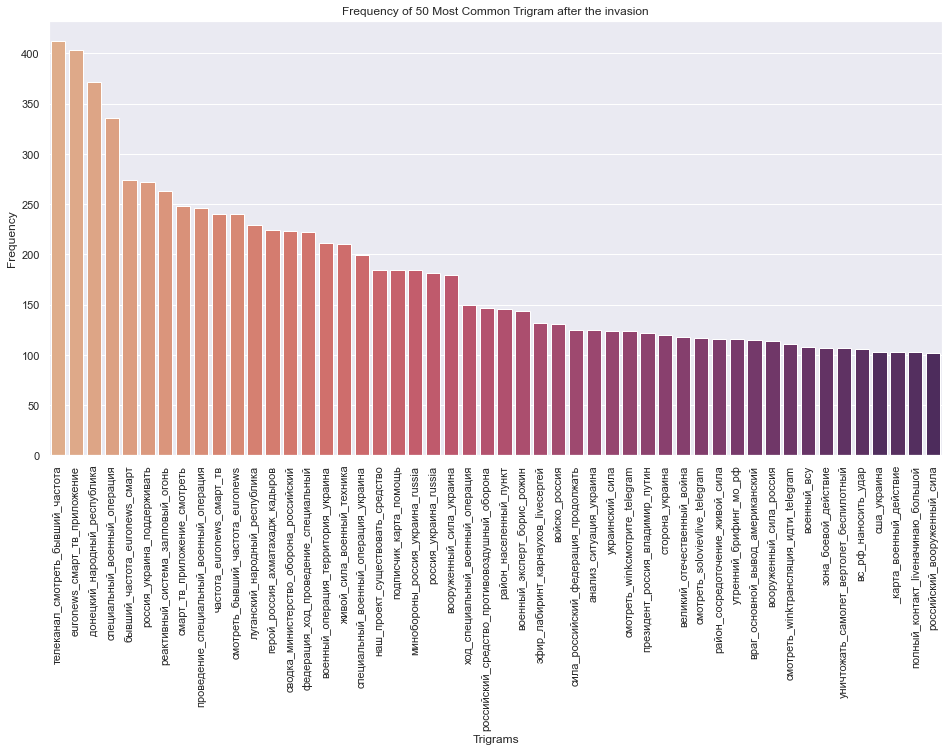

In [43]:
a_trigram_data = {"words": list(a_trigram_dict.keys()),
           "count": list(a_trigram_dict.values())}

trigram_df = pd.DataFrame.from_dict(a_trigram_data)

# Create the bar graph using Seaborn
fig, ax = plt.subplots(figsize=(16, 8))
sns.set(color_codes=True)
pal = sns.color_palette("flare", len(trigram_df[:50]["count"].tolist()))
rank = np.array(trigram_df[:50]["count"].tolist()).argsort().argsort()
ax = sns.barplot(x='words', y='count', data=trigram_df[:50], palette=np.array(pal[::-1])[rank])

# Add a title to the graph
plt.title('Frequency of 50 Most Common Trigram after the invasion')
plt.xticks(rotation=90)
plt.xlabel("Trigrams")
plt.ylabel("Frequency")

# Show the graph
plt.show()

## Trigram

### Before war

In [44]:
b_trigram = Phrases(b_bigram[b_unigram], min_count=2,threshold=3)
b_trigram = Phraser(b_trigram)
b_trigram_dict = dict()

for sent in b_trigram[b_bigram[b_unigram]]:
    for s in sent:
        if s not in b_bigram_dict.keys() and s not in b_trigram_dict.keys():
            b_trigram_dict[s]=1
        elif s not in b_bigram_dict.keys():
            b_trigram_dict[s]+=1

In [45]:
b_trigram_dict = dict(sorted(b_trigram_dict.items(), key=lambda item: item[1],reverse=True))

In [89]:
b_trigram_list = [(k, v) for k, v in b_trigram_dict.items()]

with open('before_war_trigrams.txt', 'w') as filehandle:
    for listitem in b_trigram_list[:200]:
        filehandle.write(f'{listitem}\n')

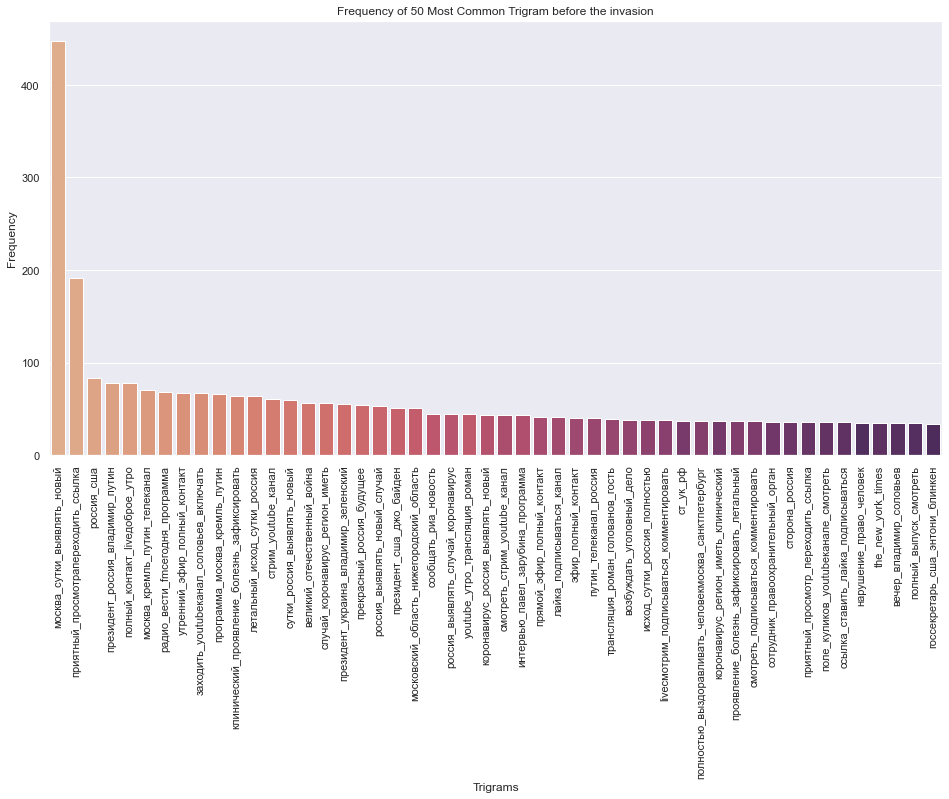

In [188]:
b_trigram_data = {"words": list(b_trigram_dict.keys()),
           "count": list(b_trigram_dict.values())}

trigram_df = pd.DataFrame.from_dict(b_trigram_data)

# Create the bar graph using Seaborn
fig, ax = plt.subplots(figsize=(16, 8))
sns.set(color_codes=True)
pal = sns.color_palette("flare", len(trigram_df[:50]["count"].tolist()))
rank = np.array(trigram_df[:50]["count"].tolist()).argsort().argsort()
ax = sns.barplot(x='words', y='count', data=trigram_df[:50], palette=np.array(pal[::-1])[rank])

# Add a title to the graph
plt.title('Frequency of 50 Most Common Trigram before the invasion')
plt.xticks(rotation=90)
plt.xlabel("Trigrams")
plt.ylabel("Frequency")

# Show the graph
plt.show()